In [1]:
# created by G Oldford 
# last modified March 25 2024

# purpose: HOTSSea v1 plots model-obs profile prob dist fncs (pdfs) for temp and salin by domain
#
# data in: pickle files output from server pyap analysis - contains obs and mod for CTDs
# data out: fig5 from manuscript, compares mean bias over each 

# notes: 
#  - input files are too large for guthub hosting so they are zipped
#  - removed the pdfs for legibility
#  - RUN216 old code for 1.02 and RUN213 old code for 1.01
#  - code requires process to get stats from all ctd's using code on server



In [10]:
import sys
import os
import yaml
import datetime as dt
import netCDF4 as nc
import numpy as np
import pickle

from matplotlib.path import Path as Path
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import matplotlib.colors as colors
from matplotlib.path import Path as Path
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import cmocean.cm as cm

import pkg_grid
import pkg_geo


go_changes = 'on'

def get_profile_pdfs(scores, class4, bb, min_sample, reg, common_profiles, common_depths, std_thres=None):
    """

    Parameters
    ----------
    scores : dict
    class4 : dict
    bb : dict
        CTD region boundaries
    min_sample : int
        Minimum number of samples per layer. Exclude layers with fewer samples.
    reg : str
        CTD region name (from the CTD_analysis_domain...yaml)
    std_thres : float, optional
        Threshold for filtering out the outlier profiles. Outliers are detected as model-obs diff values
        outside of `mean +- thres*stdev` range. No outlier detection by default.

    Returns
    -------

    """
    bounds = Path(bb[reg])
    # profiles within the region
    # c4b = [c4 for k, c4 in class4.items() if bounds.contains_point(scores[k]['ObsLocation'])]
    # TODO (2020-10-01): Check why Nones appear, fix, go back to the above
    #kc4b = [(k, c4) for k, c4 in class4.items()
    #        if scores[k] is not None and bounds.contains_point(scores[k]['ObsLocation'])]
    if common_profiles is None:
        kc4b = [(k, c4) for k, c4 in class4.items()
                if scores[k] is not None and bounds.contains_point(scores[k]['ObsLocation'])]
    else:
        kc4b = [(k, c4) for k, c4 in class4.items()
                if str(k) in common_profiles and scores[k] is not None
                and bounds.contains_point(scores[k]['ObsLocation'])]
    # early exit if no valid profiles
    if len(kc4b) == 0:
        return {'dep': [], 'bins': [], 'pdf': [], 'n': [], 'raw': [], 'outliers': []}, \
               {'dep': [], 'bins': [], 'pdf': [], 'n': [], 'raw': [], 'outliers': []}
    kb = [_[0] for _ in kc4b]  # profile names
    c4b = [_[1] for _ in kc4b]  # class4 values

    if common_profiles is None:
        z = [c4['dep'] for c4 in c4b]  # depth vectors for each profile
    else:
        z = [c4['dep'][c4['dep'] <= common_depths[common_profiles == profile_name][0]] for profile_name,c4 in zip(kb,c4b)]
    lens = [len(_) for _ in z]  # profile lengths
    maxlen = max(lens)
    z = z[np.argmax(lens)]
    # tails of nans for each profile to make them same length
    tails = [np.full(maxlen - len1, np.nan) for len1 in lens]

    def var_prep(var):
        """ Get diffs and determine outliers """
        if common_profiles is None:
            v = [c4['model'][var] - c4['obs'][var] for c4 in c4b]  # collect model-obs diffs
        else:
            mvs = [c4['model'][var][c4['dep'] <= common_depths[common_profiles == profile_name][0]] for profile_name,c4 in zip(kb,c4b)]
            ovs = [c4['obs'][var][c4['dep'] <= common_depths[common_profiles == profile_name][0]] for profile_name,c4 in zip(kb,c4b)]
            v = [mv - ov for mv,ov in zip(mvs,ovs)]

        v = [np.append(_, tail) for _, tail in zip(v, tails)]  # extend with nans to unify lengths
        v = np.column_stack(v)  # array (ndep, nprofiles)
        v_abs = np.abs(v)
        binlim = np.ceil(np.nanmax(v_abs))  # bounds for the histogram
        nv = np.sum(v_abs < binlim, axis=1)  # nans not counted here
        # exclude undersampled layers
        z_well = nv >= min_sample
        v = v[z_well, :]
        zv = z[z_well]
        # TODO Return a message
        # determine outliers
        if (std_thres is None) | (std_thres == "None"):
            iout = np.full(v.shape[1], False)
            out_names = []
        else:
            v_std = np.nanstd(v, axis=1, keepdims=True)
            v_mean = np.nanmean(v, axis=1, keepdims=True)
            iout = np.abs(v - v_mean) > std_thres * v_std  # NOTE nans are not counted as outliers here
            iout = np.any(iout, axis=0)  # profiles with outliers at ANY layer are marked as "bad"
            out_names = [kb1 for kb1, i1 in zip(kb, iout) if i1]
        return v, zv, ~iout, out_names

    def var_pdf(v, zv):
        """ PDF (normalized histogram) along dim=1 of a 2D array """
        if v.size == 0:  # shortcut if number of profiles is below min_sample
            return [], [], [], [], []
        binlim = np.ceil(np.nanmax(np.abs(v)))  # bounds for the histogram

        # GO -20230607
        num_bins = 100

        if go_changes == 'on':
          if num_bins > v.shape[1]:
            num_bins = v.shape[1]
          bins = np.linspace(-1.0 * binlim, binlim, num_bins)  # histogram bins
        else:
          bins = np.linspace(-1.0 * binlim, binlim, v.shape[1])  # histogram bins

        pdf = [np.histogram(v1, bins=bins)[0] for v1 in v]  # histogram for each depth
        pdf = np.vstack(pdf)  # (ndep, nbins)
        nv = pdf.sum(axis=1)  # hist sum for each depth
        pdf = pdf / nv[:, None]  # normalized histogram
        # inz = nv != 0  # do not divide by zero
        # pdf[inz, :] = pdf[inz, :] / nv[inz][:, None]  # normalized histogram

        # exclude undersampled layers
        z_good = nv >= min_sample
        if not z_good.any():
            zv = []
            # v = np.zeros((0, 0)) + np.nan
        else:
            nv = nv[z_good]
            zv = zv[z_good]
            pdf = pdf[z_good, :]
            v = v[z_good, :]
            # v[v == 0.] = np.nan  # why this?
        return zv, bins, pdf, nv, v

    t, zt, igood_t, out_t = var_prep('T')
    s, zs, igood_s, out_s = var_prep('S')
    igood_ts = igood_t & igood_s
    zt, bins_t, pdf_t, nt, t = var_pdf(t[:, igood_ts], zt)
    zs, bins_s, pdf_s, ns, s = var_pdf(s[:, igood_ts], zs)

    return {'dep': zt, 'bins': bins_t, 'pdf': pdf_t, 'n': nt, 'raw': t, 'outliers': out_t}, \
           {'dep': zs, 'bins': bins_s, 'pdf': pdf_s, 'n': ns, 'raw': s, 'outliers': out_s}

# added by GO 20230607, started w/ copy of get_profile_pdfs
# notes - not handling outliers, sample size filtering rn (ignore std_thres, min_sample)
# this is now implemented in code edits on server
def get_profile_means(scores, class4, bb, min_sample, reg, common_profiles, common_depths, std_thres=None):
    """

    Parameters
    ----------
    scores : dict
    class4 : dict
    bb : dict
        CTD region boundaries
    min_sample : int
        Minimum number of samples per layer. Exclude layers with fewer samples.
    reg : str
        CTD region name (from the CTD_analysis_domain...yaml)
    std_thres : float, optional
        Threshold for filtering out the outlier profiles. Outliers are detected as model-obs diff values
        outside of `mean +- thres*stdev` range. No outlier detection by default.

    Returns
    -------

    {'mean_obs': [], 'mean_mod': [], 'std_obs': [], 'std_mod': []}

    """
    bounds = Path(bb[reg])
    # profiles within the region
    # c4b = [c4 for k, c4 in class4.items() if bounds.contains_point(scores[k]['ObsLocation'])]
    # TODO (2020-10-01): Check why Nones appear, fix, go back to the above
    #kc4b = [(k, c4) for k, c4 in class4.items()
    #        if scores[k] is not None and bounds.contains_point(scores[k]['ObsLocation'])]
    if common_profiles is None:
        kc4b = [(k, c4) for k, c4 in class4.items()
                if scores[k] is not None and bounds.contains_point(scores[k]['ObsLocation'])]
    else:
        kc4b = [(k, c4) for k, c4 in class4.items()
                if str(k) in common_profiles and scores[k] is not None
                and bounds.contains_point(scores[k]['ObsLocation'])]

#     print("n profiles: ", len(kc4b))
    # early exit if no valid profiles
    if len(kc4b) == 0:
        #return {'dep': [], 'bins': [], 'pdf': [], 'n': [], 'raw': [], 'outliers': []}, \
        #       {'dep': [], 'bins': [], 'pdf': [], 'n': [], 'raw': [], 'outliers': []}
        return {'mean_obs': [], 'mean_mod': [], 'std_obs': [], 'std_mod': []}, \
               {'mean_obs': [], 'mean_mod': [], 'std_obs': [], 'std_mod': []}
    kb = [_[0] for _ in kc4b]  # profile names
    c4b = [_[1] for _ in kc4b]  # class4 values

    if common_profiles is None:
        z = [c4['dep'] for c4 in c4b]  # depth vectors for each profile
    else:
        z = [c4['dep'][c4['dep'] <= common_depths[common_profiles == profile_name][0]] for profile_name,c4 in zip(kb,c4b)]
    lens = [len(_) for _ in z]  # profile lengths
    maxlen = max(lens)
    z = z[np.argmax(lens)]
    # tails of nans for each profile to make them same length
    tails = [np.full(maxlen - len1, np.nan) for len1 in lens]

    def var_prep(var): 

        """ Get diffs and determine outliers """
        if common_profiles is None:

            # added by GO
            mvs = [c4['model'][var] for c4 in c4b]
            ovs = [c4['obs'][var] for c4 in c4b]

            #v = [c4['model'][var] - c4['obs'][var] for c4 in c4b]  # collect model-obs diffs
        else:
            mvs = [c4['model'][var][c4['dep'] <= common_depths[common_profiles == profile_name][0]] for profile_name,c4 in zip(kb,c4b)]
            ovs = [c4['obs'][var][c4['dep'] <= common_depths[common_profiles == profile_name][0]] for profile_name,c4 in zip(kb,c4b)]

            #v = [mv - ov for mv,ov in zip(mvs,ovs)]

        #v = [np.append(_, tail) for _, tail in zip(v, tails)]  # extend with nans to unify lengths
        #v = np.column_stack(v)  # array (ndep, nprofiles)
        #v_abs = np.abs(v)

        # added by GO
        mvs = [np.append(_, tail) for _, tail in zip(mvs, tails)]  # extend with nans to unify lengths
        mvs = np.column_stack(mvs)  # array (ndep, nprofiles)
        ovs = [np.append(_, tail) for _, tail in zip(ovs, tails)]  # extend with nans to unify lengths
        ovs = np.column_stack(ovs)  # array (ndep, nprofiles)


        # not sure how to translate over yet - GO
        # (filters if too few samples found at each depth)      
        #binlim = np.ceil(np.nanmax(v_abs))  # bounds for the histogram
        #nv = np.sum(v_abs < binlim, axis=1)  # nans not counted here

        # exclude undersampled layers
        #z_well = nv >= min_sample
        #v = v[z_well, :]
        #zv = z[z_well]

        # not handling outliers here - GO
        # TODO Return a message
        # determine outliers
        #if (std_thres is None) | (std_thres == "None"):
        #    iout = np.full(v.shape[1], False)
        #    out_names = []
        #else:

        #    v_std = np.nanstd(v, axis=1, keepdims=True)
        #    v_mean = np.nanmean(v, axis=1, keepdims=True)
        #    
        #    iout = np.abs(v - v_mean) > std_thres * v_std  # NOTE nans are not counted as outliers here
        #    iout = np.any(iout, axis=0)  # profiles with outliers at ANY layer are marked as "bad"
        #    out_names = [kb1 for kb1, i1 in zip(kb, iout) if i1]

        mvs_mean = np.nanmean(mvs, axis=1, keepdims=True)
        mvs_std = np.nanstd(mvs, axis=1, keepdims=True)

        ovs_mean = np.nanmean(ovs, axis=1, keepdims=True)
        ovs_std = np.nanstd(ovs, axis=1, keepdims=True)

        #return v, zv, ~iout, out_names
        return ovs_mean, mvs_mean, ovs_std, mvs_std        


    def var_pdf(v, zv):
        """ PDF (normalized histogram) along dim=1 of a 2D array """
        if v.size == 0:  # shortcut if number of profiles is below min_sample
            return [], [], [], [], []
        binlim = np.ceil(np.nanmax(np.abs(v)))  # bounds for the histogram

        # GO -20230607
        num_bins = 100

        if go_changes == 'on':
          if num_bins > v.shape[1]:
            num_bins = v.shape[1]
          bins = np.linspace(-1.0 * binlim, binlim, num_bins)  # histogram bins
        else:
          bins = np.linspace(-1.0 * binlim, binlim, v.shape[1])  # histogram bins

        pdf = [np.histogram(v1, bins=bins)[0] for v1 in v]  # histogram for each depth
        pdf = np.vstack(pdf)  # (ndep, nbins)
        nv = pdf.sum(axis=1)  # hist sum for each depth
        pdf = pdf / nv[:, None]  # normalized histogram
        # inz = nv != 0  # do not divide by zero
        # pdf[inz, :] = pdf[inz, :] / nv[inz][:, None]  # normalized histogram

        # exclude undersampled layers
        z_good = nv >= min_sample
        if not z_good.any():
            zv = []
            # v = np.zeros((0, 0)) + np.nan
        else:
            nv = nv[z_good]
            zv = zv[z_good]
            pdf = pdf[z_good, :]
            v = v[z_good, :]
            # v[v == 0.] = np.nan  # why this?
        return zv, bins, pdf, nv, v


    #t, zt, igood_t, out_t = var_prep('T') 
    #s, zs, igood_s, out_s = var_prep('S')

    t_obs_mean, t_mod_mean, t_obs_std, t_mod_std = var_prep('T') 
    s_obs_mean, s_mod_mean, s_obs_std, s_mod_std = var_prep('S') 

    #igood_ts = igood_t & igood_s
    #zt, bins_t, pdf_t, nt, t = var_pdf(t[:, igood_ts], zt)
    #zs, bins_s, pdf_s, ns, s = var_pdf(s[:, igood_ts], zs)

    return {'mean_obs': t_obs_mean, 'mean_mod': t_mod_mean, 'std_obs': t_obs_std, 'std_mod': t_mod_std}, \
           {'mean_obs': s_obs_mean, 'mean_mod': s_mod_mean, 'std_obs': s_obs_std, 'std_mod': s_mod_std}
    
def makeProfilePDFs(scores, class4, bb, minSample, reg):
    # find max diff for T and S and depth for all profiles
    maxDiffT = 0.
    maxDiffS = 0.
    maxDep = np.array([])
    count = 0
    for k in class4.keys():
        # TODO (2020-10-01): Check why Nones appear, fix, remove the if-check
        if scores[k] is None:
            continue
        # pick only belonging to this region
        if not Path(bb[reg]).contains_point(scores[k]['ObsLocation']):
            continue
        diffT = np.abs(class4[k]['model']['T'] - class4[k]['obs']['T'])
        if np.nanmax(diffT) > maxDiffT:
            maxDiffT = np.nanmax(diffT)

        diffS = np.abs(class4[k]['model']['S'] - class4[k]['obs']['S'])
        if np.nanmax(diffS) > maxDiffS:
            maxDiffS = np.nanmax(diffS)

        if len(class4[k]['dep']) > len(maxDep):
            maxDep = class4[k]['dep']
        count += 1

    diffGridT = np.linspace(-1. * np.ceil(maxDiffT), np.ceil(maxDiffT), count)
    xT, yT = np.meshgrid(diffGridT, maxDep)
    diffGridS = np.linspace(-1. * np.ceil(maxDiffS), np.ceil(maxDiffS), count)
    xS, yS = np.meshgrid(diffGridS, maxDep)

    # calculate PDFs (normalized histograms) for T and S diffs
    pdf_T = np.zeros_like(xT)
    pdf_S = np.zeros_like(xS)
    count = 0
    for k in class4.keys():  # go over profiles
        # TODO (2020-10-01): Check why Nones appear, fix, remove the if-check
        if scores[k] is None:
            continue
        if not Path(bb[reg]).contains_point(scores[k]['ObsLocation']):
            continue

        diffT = class4[k]['model']['T'] - class4[k]['obs']['T']
        T1 = np.zeros_like(maxDep)
        T1[:len(diffT)] = diffT
        diffS = class4[k]['model']['S'] - class4[k]['obs']['S']
        S1 = np.zeros_like(maxDep)
        S1[:len(diffS)] = diffS
        if count == 0:
            T = T1
            S = S1
        else:
            T = np.column_stack([T,T1])
            S = np.column_stack([S,S1])

        for i in range(len(diffT)):  # for each depth level
            # TODO Bug: This counts nans and places them in the last bin
            indT = np.digitize(diffT[i], diffGridT) - 1
            # if i == len(maxDep)-1 and indT == len(diffGridT)-1:
            #     print(f"=====count: {count}    diffT[i]: {diffT[i]}")
            indS = np.digitize(diffS[i], diffGridS) - 1
            pdf_T[i, indT] += 1
            pdf_S[i, indS] += 1
        count += 1

    N = np.sum(pdf_T, axis=1)
    for i in range(pdf_T.shape[0]):
        pdf_T[i,:] = pdf_T[i,:]/np.sum(pdf_T[i,:])
        pdf_S[i,:] = pdf_S[i,:]/np.sum(pdf_S[i,:])

    pdf_T = pdf_T[N >= minSample,:]
    pdf_S = pdf_S[N >= minSample,:]
    maxDep = maxDep[N >= minSample]
    xT,yT = np.meshgrid(diffGridT,maxDep)
    xS,yS = np.meshgrid(diffGridS,maxDep)
    if not (N >= minSample).any():
        T = np.zeros((0,0)) + np.nan
        S = np.zeros((0,0)) + np.nan
    else:
        T = T[N >= minSample,:]
        S = S[N >= minSample,:]
        N = N[N >= minSample]

        T[T == 0.] = np.nan
        S[S == 0.] = np.nan

    return {'x': xT, 'y': yT, 'pdf': pdf_T, 'raw': T}, {'x': xS, 'y': yS, 'pdf': pdf_S, 'raw': S}, N, maxDep


def get_bathy(opt):
    lon, lat = pkg_grid.tgrid(opt['file_coord'])
    lonf, latf = pkg_grid.fgrid(opt['file_coord'])
    lonfe, latfe = pkg_geo.expandf(lonf,latf) # corner grid
    depth = pkg_grid.bathymetry(opt['file_bathy'], maskfile=opt['file_mesh'])
    bathy = dict(lon=lon, lat=lat, depth=depth, lonfe=lonfe, latfe=latfe)
    return bathy

def read_CTD_domain(domain_file):
    
    data = load_yaml(domain_file)
    
#     try:
#         data = pkg_utils.load_yaml(domain_file)
#     except FileNotFoundError:
#         print("WARNING:\n CTD domain_file {} not found as a relative or absolute path".format(domain_file))
#         print(" We will try to find the domain file directly from config; this fallback will be removed in future cleanups")
#         data = pkg_utils.load_config_yaml(domain_file)

    dep = np.asarray(data['depth']).astype(float)
    depth_levels = [[dep[i],dep[i+1]] for i in range(len(dep)-1)]

    coords = {}
    for c in data['polygon_coords'].keys():
        coords[c] = np.asarray(data['polygon_coords'][c])
        # make sure the polygon is closed
        if not np.all(coords[c][-1] == coords[c][0]):
            coords[c] = np.vstack([coords[c], coords[c][0, :]])

    return depth_levels,coords


# def load_config_yaml(f):
#     configpath = os.path.normpath(os.path.dirname(__file__) + "/../config")
#     yamldata = load_yaml(os.path.join(configpath, f))
#     return yamldata


def load_yaml(yamlfile):
    """ Helper to load a YAML
    """
    def date_to_datetime(loader, node):
        """ The default YAML loader interprets YYYY-MM-DD as a datetime.date object
            Here we override this with a datetime.datetime object with implicit h,m,s=0,0,0 """
        d = yaml.constructor.SafeConstructor.construct_yaml_timestamp(loader,node)
        if type(d) is dt.date:
            d = dt.datetime.combine(d, dt.time(0, 0, 0))
        return d
    yaml.constructor.SafeConstructor.yaml_constructors[u'tag:yaml.org,2002:timestamp'] = date_to_datetime
    with open(yamlfile, 'r') as ya:
        try:
            yamldata = yaml.safe_load(ya)
        except Exception as e:
            print("Error importing YAML file {} {})".format(yamlfile,e))
            raise
    return yamldata

Loading domain file and computing bounding boxes...
Plotting DI...
Plotting SGN...
Plotting SGS...
Plotting GI...
Plotting HS...


C:\Users\Greig\AppData\Local\Temp\ipykernel_16828\2168386404.py:268: RuntimeWarning: Mean of empty slice
  ovs_mean = np.nanmean(ovs, axis=1, keepdims=True)
C:\Users\Greig\anaconda3\lib\site-packages\numpy\lib\nanfunctions.py:1670: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


Plotting JFS...


C:\Users\Greig\AppData\Local\Temp\ipykernel_16828\2168386404.py:127: RuntimeWarning: invalid value encountered in true_divide
  pdf = pdf / nv[:, None]  # normalized histogram


Skipping PS


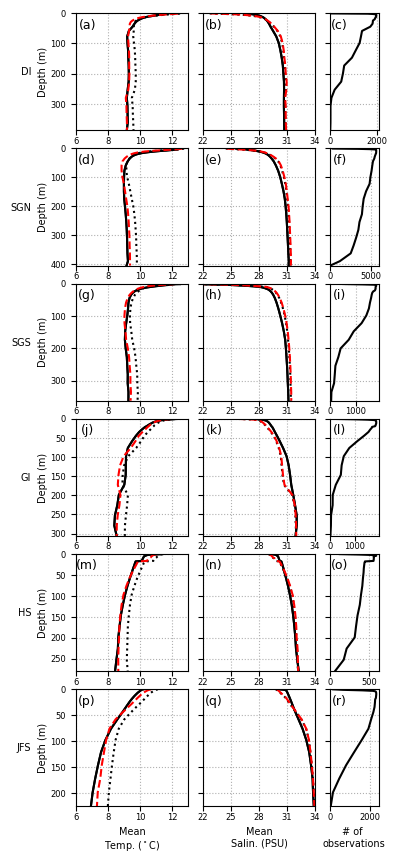

In [25]:
domain_f = '..//..//data//eval//eval_config//CTD_analysis_domain_config_template-SalishSea.yml' 
coords_f = '..//..//data//grid//coordinates_salishsea_1500m.nc' 

bathy_f = '..//..//data//bathymetry//bathy_salishsea_1500m_20210706.nc'
mesh_f = '..//..//data//mesh mask//mesh_mask_20210406.nc' 

skip_PS = True

# SalishSea1500-RUN216.yaml

min_sample = 5 # per region (default)
std_thres = 2 
formats = 'PNG'

# Get bounding boxes and map zooms
print('Loading domain file and computing bounding boxes...')
# depth_levels, coords = pkg_analyze_cast.read_CTD_domain(opt['analysis']['CTD']['domain_file'])
depth_levels, coords = read_CTD_domain(domain_f)
bb = {}
for k in coords.keys():
    # make sure the polygon is closed
    if np.all(coords[k][-1] == coords[k][0]):
        bb[k] = coords[k]
    else:
        bb[k] = np.vstack([coords[k], coords[k][0, :]])

# bathy = pkg_plot.get_bathy(opt)
lon, lat = pkg_grid.tgrid(coords_f)
lonf, latf = pkg_grid.fgrid(coords_f)
lonfe, latfe = pkg_geo.expandf(lonf,latf) # corner grid
depth = pkg_grid.bathymetry(bathy_f, maskfile=mesh_f)
bathy = dict(lon=lon, lat=lat, depth=depth, lonfe=lonfe, latfe=latfe)


modelruns_info = {'SalishSea1500-RUN203': {'path': 'D:/temp_nemo/RUN203_PLOTS_SCORES/',
                                            'colour': 'r', 
                                            'shortcode': 'RUN203', 'experiment': False}, 
                      'SalishSea1500-RUN216': {'path': 'D:/temp_nemo/RUN216/',
                                            'colour': 'b', 
                                           'shortcode': 'RUN216', 'experiment': False}#,
#                      'SalishSea500-201905': {'path': 'D:/temp_nemo/SS500/',
#                                            'colour': 'g', 
#                                            'shortcode': '201905', 'experiment': True}
                 }

modelruns_info = {'SalishSea1500-RUN203': {'path': 'D:/nemo_outputs/ANALYSIS/SalishSea1500-RUN203/PROCESS/CTD/',
                                            'colour': 'r', 
                                            'shortcode': 'RUN203', 'experiment': False}, 
                      'SalishSea1500-RUN216': {'path': 'D:/nemo_outputs/ANALYSIS/SalishSea1500-RUN216/PROCESS/CTD/',
                                            'colour': 'b', 
                                           'shortcode': 'RUN216', 'experiment': False}#,
#                      'SalishSea500-201905': {'path': 'D:/temp_nemo/SS500/',
#                                            'colour': 'g', 
#                                            'shortcode': '201905', 'experiment': True}
                 }




# manual setting of x-axis limits
xLimT = 3.
xLimS = 5.       #Go 20230411 commented line to use these below back in
lw1 = 1        #GO 20230411 CRMSE
lw2 = 1      #GO 20230411  +/- lines
fs1 = 7
fs2 = 6 #  fontsize tics
gamma1 = 0.65      #Go 20230411 for powernorm color norm
fig_dim_1 = 8 #w
fig_dim_2 = 11
# fig_dim_2 = 3 #h
min_x_salt_mean = 22 # for plotting, found through trial and error across all plots
max_x_salt_mean = 34
min_x_temp_mean = 6
max_x_temp_mean = 13
grd_hspace = 2 # space of axis vert reserved for labels
grd_wspace = 0.3


fig = plt.figure(figsize=(fig_dim_1, fig_dim_2))

#gs = gridspec.GridSpec(1, 6)
len_bb = len(bb.keys())
if skip_PS == True: 
    len_bb -= 1
gs = gridspec.GridSpec(5*len_bb+2, 10,hspace=grd_hspace,wspace=grd_wspace)



# for region in bounding box list
n_reg = 0
for reg in bb.keys():
    if reg == "PS" and skip_PS == True:
        print('Skipping PS')
        n_reg+=1
        continue
    else:
        print('Plotting ' + reg + '...')
    
#     if n_reg >= 2: #debug
#         continue
    
    # set which gridspec row for subplots
    gs_row_st = 0+n_reg*5
    gs_row_en = 5+n_reg*5
    
    # GO 20230815- loop to show the bias correction
    n_run = 0
    for run in modelruns_info.keys():
        
        path1 = modelruns_info[run]['path']
        CTD_f = 'CTDcast_metrics_hindcast_fewdepths.pickle'
        with open(os.path.join(path1,CTD_f), 'rb') as fid:
            CTD_scores = pickle.load(fid)

        # returns pcolormeshes for plots
        plotT,plotS,N,maxDep = makeProfilePDFs(CTD_scores[run]['scores'],CTD_scores[run]['class4'],bb,min_sample,reg)
        plotT, plotS = get_profile_pdfs(CTD_scores[run]['scores'], CTD_scores[run]['class4'], bb, min_sample, reg, None, None, std_thres)

        if len(plotT['dep']) == 0 and len(plotS['dep']) == 0:
            print(f'Region {reg} has no profiles. Not making a plot for this')
            continue

        # GO added below
        plotT_mean, plotS_mean = get_profile_means(CTD_scores[run]['scores'], CTD_scores[run]['class4'], bb, min_sample, reg, None, None, std_thres)
        # for now take dep from fnc above
        plotT_mean['dep'] = plotT['dep']
        plotS_mean['dep'] = plotS['dep']

        # temporarily turn this off - GO 20230607
        #save_outliers(plotT['outliers'], plotS['outliers'], os.path.join(outdir, f"{reg}_outliers.txt")     

        axt_mean = plt.subplot(gs[gs_row_st:gs_row_en, :2])
        axs_mean = plt.subplot(gs[gs_row_st:gs_row_en, 2:4], sharey=axt_mean)

        ax = [axt_mean, axs_mean]   

        # plot the mean temps
#         ax[0].set_ylabel('Pressure (dBar)', fontsize=fs1, labelpad=2)
        ax[0].set_ylabel('Depth (m)', fontsize=fs1, labelpad=2)
        dep_n = len(plotT_mean['dep'])
        
        if n_run == 0: 
            color_l = 'k'
            line_l = ":"
        else: 
            color_l = 'r'
            line_l = "--"
        
        obs_t_mean = plotT_mean['mean_obs'][0:dep_n]
        ax[0].plot(obs_t_mean, plotT_mean['dep'], 'k-')
        mod_t_mean = plotT_mean['mean_mod'][0:dep_n]
        ax[0].plot(mod_t_mean, plotT_mean['dep'], color_l+line_l)
        
        mean_obs = Line2D([], [], color='k', lw=lw2)
        mean_mod = Line2D([], [], color='k', ls='--', lw=lw2)
#         ax[0].legend([mean_obs, mean_mod], ['Obs.', 'Mod.'], fontsize=fs1, bbox_to_anchor=[0.4, -0.4])
#         #ax[0].legend([mean_obs, mean_mod], ['Obs.', 'Mod.'], fontsize=fs1, loc='upper left')


        # plot the mean salin
        dep_n = len(plotS_mean['dep'])
        obs_s_mean = plotS_mean['mean_obs'][0:dep_n]
        ax[1].plot(obs_s_mean, plotS_mean['dep'], 'k-')
        mod_s_mean = plotS_mean['mean_mod'][0:dep_n]
        ax[1].plot(mod_s_mean, plotS_mean['dep'], color_l+line_l)

        # don't plot values deeper than 2000 m, arbitrarily based on depth of ARGO profiles
        zMax = np.min(np.array([2000., max(plotT['dep'][-1], plotS['dep'][-1])]))

        xlabs = [u'$\Delta$ Temp.\nMod. - Obs. ($^\circ$C)',
                 u'$\Delta$ Salin.\nMod. - Obs. (psu)']

        bias = Line2D([], [], color='k', lw=lw2)
        rms = Line2D([], [], color='k', ls='--', lw=lw2)
#         ax[1].legend([bias, rms], ['Bias', 'CRMSE'], fontsize=fs1, bbox_to_anchor=[0.2, -0.4])
#         #ax[1].legend([bias, rms], ['Bias', 'CRMSE'], fontsize=fs1, loc='upper left')

        
            

            #title w/ region and model run
#             ax[4].text(1.18, 0.98, reg + '\n' + run, ha='left', va='top', transform=ax[2].transAxes)
            # text above is in data units for position so use title
        
#         # Tag the plots if outliers were excluded.
#         # With no detected outliers, the plots from the "no-outlier" run are overwritten
#         if len(plotT['outliers']) > 0 or len(plotS['outliers']) > 0:
#             tag = '_without_outliers'
#         else:
#             tag = ''
#     save_path = os.path.join(outdir, reg + f'_ProfilePDFAndMean{tag}')
#     pkg_plot.figure_saver(save_path, formats, fig, dpi=450, bbox_inches='tight')
# plt.close()
        n_run += 1
    
    
# # of obs plot
    ax.append(plt.subplot(gs[gs_row_st:gs_row_en,4], sharey=axt_mean))
    # not sure what this is for -GO
    #ax.append(fig.add_axes([0.8, 0.3, 0.02, 0.4]))
    ax[2].plot(plotT['n'], plotT['dep'], color='k', label='T')

    if len(plotT['n']) != len(plotS['n']) or np.any(plotT['n'] != plotS['n']):
        ax[2].plot(plotS['n'], plotS['dep'], '--', color='k', label='S')
        #ax[4].legend(fontsize=fs1)

    ax[2].grid(which='both')
    ax[2].set_ylim(0., zMax)
    ax[2].set_xlim(0, 1.05 * max(plotT['n'].max(), plotS['n'].max()))

    ax[0].invert_yaxis()

#         if reg == "DI":
#             subtitle = "Discovery Is. (DI)" 
#         elif reg == "SGN":
#             subtitle = "Strait of Georgia North (SGN)"
#         elif reg == "SGS":
#             subtitle = "Strait of Georgia South (SGS)"
#         elif reg == "GI":
#             subtitle = "Southern Gulf Islands (GI)"
#         elif reg == "HS":
#             subtitle = "Haro Strait (HS)"
#         elif reg == "PS":
#             subtitle = "Puget Sound (PS)"
#         elif reg == "JFS":
#             subtitle = "Juan de Fuca Strait (JFS)"
#         else:
#             subtitle = reg
    subtitle=reg

    ax[0].set_title(subtitle,fontdict={'fontsize':fs1},loc='right',y=0.4,x=-0.4)

    # format the axes for means
    ax_n = 0
    for a in [ax[0], ax[1]]:
        if ax_n == 0:
            a.set_xlim(min_x_temp_mean,max_x_temp_mean)
            ticks = np.arange(min_x_temp_mean, max_x_temp_mean+1, 2)
        else:
            a.set_xlim(min_x_salt_mean,max_x_salt_mean)
            ticks = np.arange(min_x_salt_mean, max_x_salt_mean+3, 3)
        a.set_xticks(ticks)
#             a.grid(which='both')
        plt.sca(a)
        plt.tick_params(axis='x', labelsize=fs2, pad=1)
        plt.tick_params(axis='y', labelsize=fs2)

        ax_n+=1

    for a in [ax[1], ax[2]]:
        plt.sca(a)
        plt.tick_params(axis='y', labelleft=False)
        plt.tick_params(axis='x', labelsize=fs2, pad=1)

    for a in [ax[0], ax[1], ax[2]]:
        plt.sca(a)
        plt.grid(which='both', linestyle=":")


    if n_reg == len_bb - 1:
        ax[0].set_xlabel("Mean\nTemp. ($^\circ$C)", fontsize=fs1)
        ax[1].set_xlabel("Mean\nSalin. (PSU)", fontsize=fs1)
        ax[2].set_xlabel('# of \nobservations', fontsize=fs1)
    
    n_reg += 1
    
letters = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)', 
          '(i)', '(j)', '(k)', '(l)', '(m)', '(n)', '(o)', '(p)', '(q)', '(r)']
let_clr = 'k'
let_y = 0.87
let_xs = [0.1, 0.1, 0.2,
          0.1, 0.1, 0.2,
          0.1, 0.1, 0.2,
          0.1, 0.1, 0.2,
          0.1, 0.1, 0.2,
          0.1, 0.1, 0.2
         ]
l = 0
for ax in fig.get_axes():
    letter = letters[l]
    let_x = let_xs[l]
    ax.text(let_x, let_y, letter, transform=ax.transAxes, ha='center', color=let_clr, fontsize=9, zorder=1000)
    l += 1

plt.savefig('..//..//figs//Fig05.pdf', dpi=350)
plt.savefig('..//..//figs//Fig05.png', dpi=350)